## Luke Meszar
## Homework 3

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

## Problem 1

In [79]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
plt.style.use('ggplot')
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = np.linspace(0, 1, m)
    y, x = np.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y, u, forcing, g0, p, epsilon, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = np.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = np.array([idx(*pair) for pair in [(i-1,j-1),(i-1,j), (i-1,j+1), (i,j-1),
                                                           (i,j),(i,j+1),(i+1,j-1), (i+1,j), (i+1,j+1)]])
            large_grad = np.array([[0,-1,0,0,1,0,0,0,0],
                                  [-1/4,-1/4,0,0,0,0,1/4,1/4,0],
                                  [0,0,0,0,-1,0,0,1,0],
                                  [0,-1/4,-1/4,0,0,0,0,1/4,1/4],
                                  [-1/4,0,1/4,1/4,0,1/4,0,0,0],
                                  [0,0,0,-1,1,0,0,0,0],
                                  [0,0,0,-1/4,0,1/4,-1/4,0,1/4],
                                  [0,0,0,0,-1,1,0,0,0]])/h
            # Stencil to evaluate gradient at four staggered points
            grad = np.array([[0,-1,0,0,1,0,0,0,0],
                                [0,0,0,-1,1,0,0,0,0],
                                [0,0,0,0,-1,1,0,0,0],
                                [0,0,0,0,-1,0,0,1,0]]) / h

            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = np.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            gradx = large_grad[0:4] @ ustencil
            grady = large_grad[4:] @ ustencil
            kappa = (1/2*epsilon**2+1/2*(gradx**2+grady**2)**2)**((p-2)/2)
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad) #picard solver
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J



 0: anorm 1.000000e+00
 1: anorm 9.237940e-02
 2: anorm 1.453359e-02
 3: anorm 1.769884e-03
 4: anorm 1.987757e-04
 5: anorm 2.133446e-05
 6: anorm 2.237972e-06
 7: anorm 2.319192e-07
 8: anorm 2.387815e-08
 9: anorm 2.449964e-09


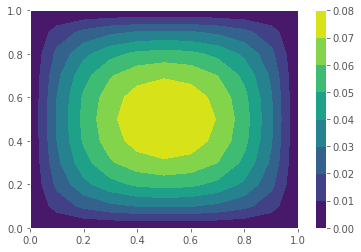

In [80]:
def solve_nonlinear(h, g0, p, epsilon, dirichlet, maxit=50, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(maxit):
        F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               g0, p, epsilon, dirichlet=dirichlet)
        anorm = np.linalg.norm(F, np.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i

x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, p=12,epsilon=1.4,
                             dirichlet=((0,-1),(0,-1)),
                             verbose=True, maxit=500)
plt.contourf(x, y, u)
plt.colorbar();

In [81]:
def test_convergence_speed(p_values,maxit,epsilon):
    convergence_values = []
    for p in p_values:
        x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, p=p,epsilon=epsilon,
                             dirichlet=((0,-1),(0,-1)), maxit=maxit)
        convergence_values.append(i)
    return convergence_values

## Convergence study based on $p$ and $\epsilon$

Text(0,0.5,'number of iterations')

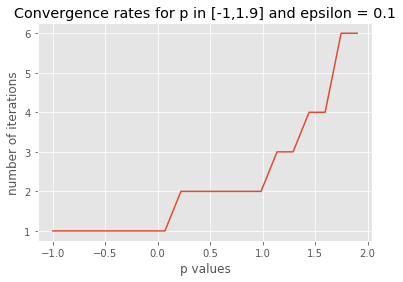

In [82]:
p_values = np.linspace(-1,1.9,20)
convergence_values = test_convergence_speed(p_values,100,0.1)
plt.plot(p_values, convergence_values)
plt.title("Convergence rates for p in [-1,1.9] and epsilon = 0.1")
plt.xlabel("p values")
plt.ylabel("number of iterations")

Text(0,0.5,'number of iterations')

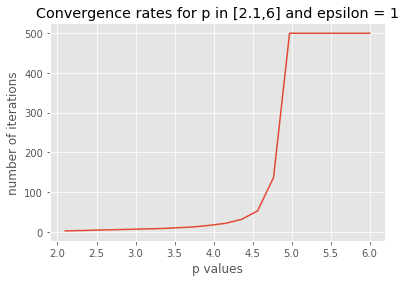

In [83]:
p_values = np.linspace(2.1,6,20)
convergence_values = test_convergence_speed(p_values,500,1)
plt.plot(p_values, convergence_values)
plt.title("Convergence rates for p in [2.1,6] and epsilon = 1")
plt.xlabel("p values")
plt.ylabel("number of iterations")

Above we see that larger values of $p$ and $\epsilon = 1$, we don't get convergence in 500 iterations. However, as see below, if we just increase $\epsilon$ to $1.2$, we get converge for all $p \le 6$. Raising $\epsilon$ again means we can convere with higher values of $p$.

Text(0,0.5,'number of iterations')

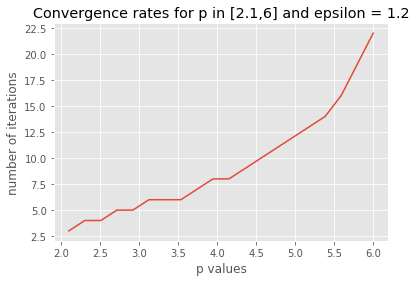

In [84]:
p_values = np.linspace(2.1,6,20)
convergence_values = test_convergence_speed(p_values,500,1.2)
plt.plot(p_values, convergence_values)
plt.title("Convergence rates for p in [2.1,6] and epsilon = 1.2")
plt.xlabel("p values")
plt.ylabel("number of iterations")

Text(0,0.5,'number of iterations')

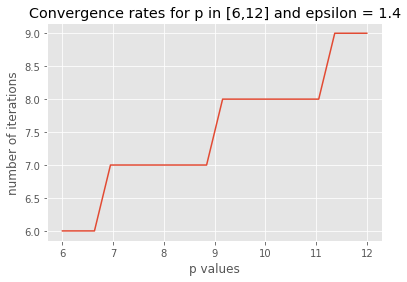

In [85]:
p_values = np.linspace(6,12,20)
convergence_values = test_convergence_speed(p_values,500,1.4)
plt.plot(p_values, convergence_values)
plt.title("Convergence rates for p in [6,12] and epsilon = 1.4")
plt.xlabel("p values")
plt.ylabel("number of iterations")

## Problem 2

In [111]:
def fsolve_newtonkrylov(disc, u0, epsilon=1e-8, rtol=1e-6, maxit=50, verbose=False):
    u = u0.copy().flatten()
    Fu,J = disc(u)
    norm0 = np.linalg.norm(Fu)
    for i in range(maxit):
        def Ju_fd(v):
            Fuepsilon, _ = disc(u + epsilon*v)
            return (Fuepsilon - Fu)/ epsilon
        Jprecond = sp.linalg.factorized(J)
        Jpreop = sp.linalg.LinearOperator((len(Fu),len(u)), matvec=Jprecond)
        Ju = sp.linalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
        du, info = sp.linalg.gmres(Ju, Fu, atol=1e-06, M=Jpreop)
        if info != 0:
            print(np.linalg.norm(Ju @ du - Fu), norm)
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        Fu, J = disc(u)
        norm = np.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                  .format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

def solve_nonlinear_krylov(h, g0, p, epsilon, dirichlet, maxit=50, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    F, _ = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               g0, p, epsilon, dirichlet=dirichlet)
    _, i = fsolve_newtonkrylov(lambda u: nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               g0, p, epsilon, dirichlet=dirichlet), u, rtol=1e-6, verbose=verbose)
    return i
    
solve_nonlinear_krylov(.1, lambda x,y: 0*x, p=5,epsilon=1.5,
                             dirichlet=((0,-1),(0,-1)),
                             verbose=True, maxit=500)

Newton 0 anorm 2.39e-02 rnorm 2.66e-03
Newton 1 anorm 2.27e-06 rnorm 2.52e-07


1

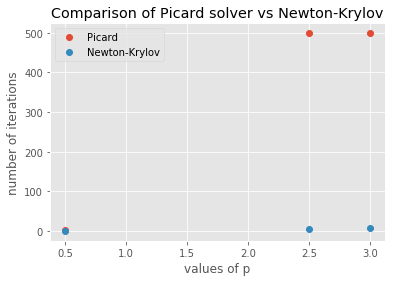

In [108]:
ps = [0.5,2.5,3]
epsilon = 0.1
krylov_iters = []
for p in ps:
    krylov_iters.append(solve_nonlinear_krylov(.1, lambda x,y: 0*x, p=p,epsilon=0.1,
                             dirichlet=((0,-1),(0,-1)),
                             verbose=False, maxit=500))
picard_iters = test_convergence_speed(p_values=ps,epsilon=0.1,maxit=500)
plt.plot(ps, picard_iters, 'o', label='Picard')
plt.plot(ps,krylov_iters, 'o', label='Newton-Krylov')
plt.xlabel('values of p')
plt.ylabel('number of iterations')
plt.title('Comparison of Picard solver vs Newton-Krylov')
plt.legend(loc='upper left')

We see that in the two of the cases run here, the Newton-Krylov method takes a lot less iterations to converge than Picard. The other case, they take a similar number of steps. It seems to be the case that Picard is better in some instances and Newton-Krylov is better in others. It is also worth noting that some of the steps for the Krylov method take a lot longer than a step for the Picard solver. So, while it may take fewer iterations to converge, it can take a significantly more time. 

## Problem 3

It would be possible to implement a full Newton solver. It would require discretizing $-\nabla(\kappa'(\nabla u)\delta u\nabla u + \kappa(\nabla u)\nabla\delta u)$. Computing the analytic derivative of $\kappa(\nabla u)$ is difficult, but it wouldn't be too hard if we did it discretely. If we knew $\kappa(\nabla u)$ at enough points around the point $u_i$, we c